In [1]:
%load_ext autoreload

In [6]:
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
from minopy.lib.utils import est_corr_py
import minopy.simulation as mnp
from skimage.measure import label
import pandas as pd
from scipy import linalg as LA
from minopy.lib.utils import sequential_phase_linking_py, phase_linking_process_py, datum_connect_py
import matplotlib.colors as mcolors

def custom_cmap(vmin=0, vmax=1):
    """ create a custom colormap based on visible portion of electromagnetive wave."""

    from minopy.spectrumRGB import rgb
    rgb = rgb()
    import matplotlib as mpl
    cmap = mpl.colors.ListedColormap(rgb)
    norm = mpl.colors.Normalize(vmin, vmax)

    return cmap, norm

In [24]:
lamda = 56.0 #wavelength (mm)
n_img = 100
n_shp = 300
velocity = 4 #mm/y
velocity_fading = 50 #mm/y
tmp_bl = 6 #days

vel_phase = velocity/365*4*np.pi/lamda    #0.0024 # rad/day
decorr_days = 50
decorr_days_seasonal = 400

vel_fading = velocity_fading/365*4*np.pi/lamda  # 0.031 # rad/day
decorr_days_fading = 11

gamma0 = 0.6
gammaf_decor = 0
gammaf_cor = 0.1
gamma_fading = 0.18   

In [185]:
## no seasonal
temp_baseline = np.ogrid[0:(tmp_bl * n_img):tmp_bl]

coh_sim_S = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_decor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=False)
coh_sim_L = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_cor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=False)

CCGsam_Sterm = mnp.simulate_neighborhood_stack(coh_sim_S, neighborSamples=n_shp)
CCGsam_Lterm = mnp.simulate_neighborhood_stack(coh_sim_L, neighborSamples=n_shp)

coh_est_S = np.array(est_corr_py(CCGsam_Sterm))
coh_est_L = np.array(est_corr_py(CCGsam_Lterm))


cov_S = mnp.CRLB_cov(coh_sim_S, n_shp)
cov_L = mnp.CRLB_cov(coh_sim_L, n_shp)
crl_S = np.hstack([0,np.sqrt(np.diag(cov_S))])
crl_L = np.hstack([0,np.sqrt(np.diag(cov_L))])


In [186]:
#### Sequential EVD
phas = -vel_phase * temp_baseline

ph_stbas, noval, temp_quality = phase_linking_process_py(CCGsam_Sterm, 0, b'StBAS', False, 4)
ph_stbas_short = np.angle(np.array(ph_stbas)).reshape(-1, 1) 

ph_stbas, noval, temp_quality = phase_linking_process_py(CCGsam_Lterm, 0, b'StBAS', False, 4)
ph_stbas_long = np.angle(np.array(ph_stbas)).reshape(-1, 1) 


num_seq = np.int(n_img // 10)
ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Sterm, b'EVD', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EVD_short = np.angle(np.array(ph_vec)).reshape(-1, 1) 

ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Lterm, b'EVD', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EVD_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 

#### Sequential EMI
ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Sterm, b'EMI', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EMI_short = np.angle(np.array(ph_vec)).reshape(-1, 1) 

ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Lterm, b'EMI', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EMI_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 


#### Sequential PTA
ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Sterm, b'PTA', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_PTA_short = np.angle(np.array(ph_vec)).reshape(-1, 1)

ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Lterm, b'PTA', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_PTA_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 

In [188]:

def real_time(compressed=False, old_images=False, new_image=None, mini_stack_size=10, method=b'EMI'):
    
    ni = new_image.shape[0]
    
    if compressed is False:
        nc = 0
    else:
        nc = compressed.shape[0]
        
    
    if old_images is False:
        no = 0
    else:
        no = old_images.shape[0]
        
    new_stack = new_image[:, :].reshape(1, -1)
    
    if no > 0:
        new_stack = np.concatenate((old_images, new_image), axis=0)
        
    res_old_images = new_stack[:, :].reshape(-1, new_image.shape[1])
        
    if nc > 0:
        
        new_stack = np.concatenate((compressed, new_stack), axis=0)
        
    if ni + no < mini_stack_size:
        do_squeeze = False
    else:
        do_squeeze = True
    
    phc_new, res_compressed, temp_quality = phase_linking_process_py(new_stack, nc, method, do_squeeze, 0)
    
    if not do_squeeze:
        res_compressed = compressed
        if old_images is False:
            res_old_images = new_image
        else:
            res_old_images = np.concatenate((old_images, new_image), axis=0)
    else:
        res_old_images = False
        res_compressed = np.array(res_compressed).reshape(1, -1)
        
    if not compressed is False and do_squeeze:
        res_compressed = np.concatenate((compressed, res_compressed), axis=0)
    
            
    return phc_new, temp_quality, res_compressed, res_old_images
    

old_images_S = False
compressed_S = False
phc_final_S = []
corrections_S = []
old_images_L = False
compressed_L = False
phc_final_L = []
corrections_L = []


for t in range(n_img):
    
    new_image_S = CCGsam_Sterm[t, :].reshape(1, -1)
    new_image_L = CCGsam_Lterm[t, :].reshape(1, -1)
    
    phc_new_S, temp_quality, compressed_S, old_images_S = real_time(compressed=compressed_S, 
                                                             old_images=old_images_S, 
                                                             new_image=new_image_S, 
                                                             mini_stack_size=10, 
                                                             method=b'EMI')
    
    phc_new_L, temp_quality, compressed_L, old_images_L = real_time(compressed=compressed_L, 
                                                             old_images=old_images_L, 
                                                             new_image=new_image_L, 
                                                             mini_stack_size=10, 
                                                             method=b'EMI')
    if t == 0:
        phc_final_S.append(phc_new_S[0])
        phc_final_L.append(phc_new_L[0])

    else:
        phc_final_S.append(phc_new_S[-1])
        phc_final_L.append(phc_new_L[-1])
        
    if not compressed_S is False:
        ph_vec_S = datum_connect_py(compressed_S, np.array(phc_final_S).astype(np.complex64), 10)
        corrections_S.append(np.angle(ph_vec_S[-1]) - np.angle(phc_final_S[-1]))
    else:
        corrections_S.append(0)
        
    if not compressed_L is False:
        ph_vec_L = datum_connect_py(compressed_L, np.array(phc_final_L).astype(np.complex64), 10)
        corrections_L.append(np.angle(ph_vec_L[-1]) - np.angle(phc_final_L[-1]))
    else:
        corrections_L.append(0)
    

phc_final_S = np.array(phc_final_S) 
phc_final_L = np.array(phc_final_L) 
        
phc_final_S_c = phc_final_S * np.exp(1j*np.array(corrections_S))
phc_final_L_c = phc_final_L * np.exp(1j*np.array(corrections_L))

Text(0.5, 1.0, 'Long term coherent')

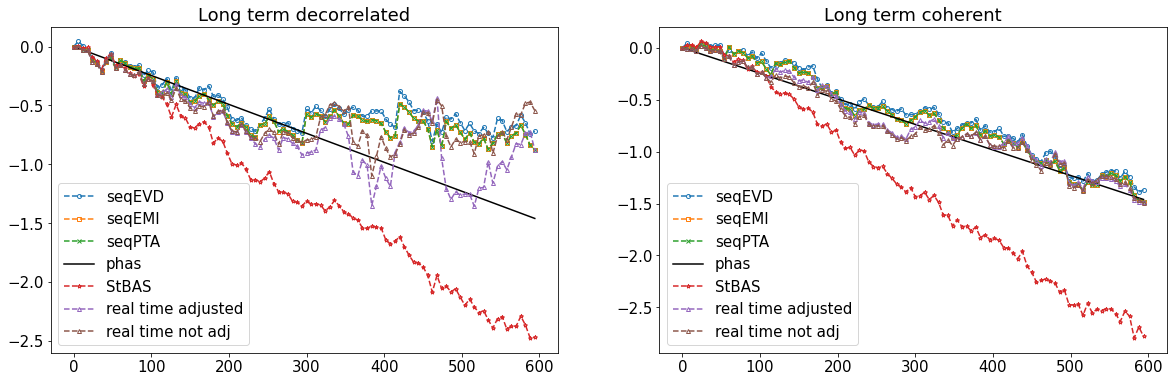

In [200]:
msize=4
plt.rcParams["font.size"] = "15"

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax = axs[0]
ax.plot(temp_baseline, ph_vec_EVD_short, 'o--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, ph_vec_EMI_short, 's--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, ph_vec_PTA_short, 'x--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, phas,'k-', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, ph_stbas_short, '*--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, np.angle(np.array(phc_final_S_c)), '^--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, np.angle(np.array(phc_final_S)), '^--', markersize=msize, markerfacecolor='None')
ax.legend(('seqEVD', 'seqEMI', 'seqPTA', 'phas', 'StBAS','real time adjusted', 'real time not adj'))

ax.set_title('Long term decorrelated')


ax = axs[1]
ax.plot(temp_baseline, ph_vec_EVD_long, 'o--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, ph_vec_EMI_long, 's--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, ph_vec_PTA_long, 'x--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, phas,'k-', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, ph_stbas_long, '*--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, np.angle(np.array(phc_final_L_c)), '^--', markersize=msize, markerfacecolor='None')
ax.plot(temp_baseline, np.angle(np.array(phc_final_L)), '^--', markersize=msize, markerfacecolor='None')
ax.legend(('seqEVD', 'seqEMI', 'seqPTA', 'phas', 'StBAS', 'real time adjusted','real time not adj'))

ax.set_title('Long term coherent')